## Loading data and initializing parameters

In [1]:
from policies.network_policies.decentralized.network_adaptive_ftpl import NetworkAdaptiveFTPL
from policies.network_policies.decentralized.network_ftpl import NetworkFTPL
from policies.network_policies.decentralized.network_lfu import NetworkLFU
from policies.network_policies.decentralized.network_lru import NetworkLRU

import numpy as np

from utilities import display_single_level_statistics
from simulation.simulation_parameters import SimulationParameters
from simulation.simulation_statistics import SimulationStatistics
from simulation.simulation_runner import SimulationRunner
from policies.ftpl_policy import FTPLPolicy
from policies.lfu_policy import LFUPolicy
from policies.lru_policy import LRUPolicy
from policies.policy import Policy
from typing import List
from data.path import DataPath
from utilities import display_multi_level_statistics
from data.loaders import Dataset, load_bipartite_traces
from data.loaders import load_online_cache_trace
from data.loaders import load_movielens
from factories.cache_factory import get_client_cache_connections



## Defining single cache simulations

In [2]:
from factories.cache_factory import get_expert_iawm_policy


def run_single_cache_simulation(ds: Dataset, cache_size: int):
    policies: List[Policy] = [
        LRUPolicy(cache_size),
        LFUPolicy(cache_size),
        FTPLPolicy(cache_size, ds.catalog_size, ds.trace.size, discount_rate=1),
        get_expert_iawm_policy(cache_size, ds.catalog_size, ds.trace.size, discount_rates=list(np.arange(0, 1.5, 0.01))),
    ]

    runner = SimulationRunner(threads=len(policies))
    parameters = SimulationParameters(ds.trace, policies)
    statistics: List[SimulationStatistics] = runner.run_simulations(parameters)
    display_single_level_statistics(statistics)

## Define bipartite simulation

In [3]:
from policies.network_policies.network_policy import NetworkPolicy
from data.loaders import BiPartiteDataset


def run_multi_cache_simulation(
        policies: List[NetworkPolicy],
        data: BiPartiteDataset
):
    runner = SimulationRunner(threads=min([len(policies), 10]))
    statistics = runner.run_bipartite_simulations(policies, data)
    display_multi_level_statistics(statistics)

## Run single cache simulation

In [4]:
single_cache_size = 50
datasets: List[Dataset] = [
    load_movielens(DataPath.MOVIE_LENS, catalog_size=single_cache_size * 100, trace_length=100_000),
    load_online_cache_trace(DataPath.OSCILLATOR),
    load_online_cache_trace(DataPath.CHANGING_OSCILLATOR),
    load_online_cache_trace(DataPath.CHANGING_POPULARITY_CATALOG),
    load_online_cache_trace(DataPath.PSN_CATALOG),
    load_online_cache_trace(DataPath.FIXED_POPULARITY_CATALOG),
    load_online_cache_trace(DataPath.SN_OSCILLATOR)
]

for dataset in datasets:
    print(
        f'=========== '
        f'{dataset.name.split("/")[-1].split(".")[0]},'
        f' cache at {round(100 * single_cache_size / dataset.catalog_size, 1)}%'
        f' ==========='
    )
    run_single_cache_simulation(dataset, single_cache_size)

## Load BiPartite data

In [5]:
data = load_bipartite_traces() #  T=1500, cat=50

## Run bipartite simulation

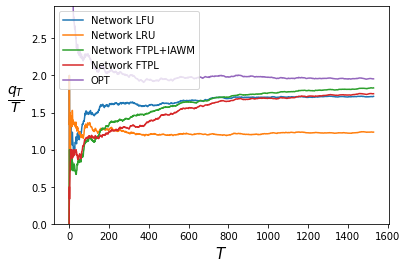

In [9]:
cache_size = 5
clients = len(data.traces)
caches = 4
d_regular_degree = 2
random_connections = get_client_cache_connections(clients, caches, d_regular_degree)
optimal_connections = [
    [0],
    [0],
    [1],
    [1],
    [2, 3],
    [2, 3]
]
adversarial_connections = [
    [0, 3],
    [1, 2],
    [1],
    [3],
    [2],
    [0]
]
time_horizon = data.traces[0].size
network_caches = [
    NetworkLFU(
        caches,
        adversarial_connections,
        data.catalog_size,
        cache_size
    ),
    NetworkLRU(
        caches,
        adversarial_connections,
        data.catalog_size,
        cache_size
    ),
    NetworkAdaptiveFTPL(
        caches,
        adversarial_connections,
        data.catalog_size,
        cache_size,
        list(np.arange(0.5, 1.01, 0.001)),
        time_horizon
    ),
    NetworkFTPL(
        caches,
        adversarial_connections,
        data.catalog_size,
        cache_size,
        time_horizon
    )
]

run_multi_cache_simulation(network_caches, data)